<h1>   Character level language model - Dinosaurus land </h1>

Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go beserk, so choose wisely! 

<table>
<td>
<img src="images/dino.jpg" style="width:250;height:300px;">

</td>

</table>

Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this [dataset](dinos.txt). (Feel free to take a look by clicking the previous link.) To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 

By completing this assignment you will learn:

- How to store text data for processing using an RNN 
- How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
- How to build a character-level text generation recurrent neural network
- Why clipping the gradients is important

We will begin by loading in some functions that we have provided for you in `rnn_utils`. Specifically, you have access to functions such as `rnn_forward` and `rnn_backward` which are equivalent to those you've implemented in the previous assignment. 

In [1]:
import numpy as np
from rnn_utils import *
from utils import *
import random

## 1 - Problem Statement

### 1.1 - Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [2]:
data = open('dinos.txt', 'r').read()
data = data.lower()
# replace crappy characters (we are not using a bad copy of the data unfortunately...)
for char in ['»','¿','ï']:
    data = data.replace(char, '')

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)


print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 16961 total characters and 27 unique characters in your data.


The characters are a-z (26 characters) plus the "\n" (or newline character), which in this assignment plays a role similar to the `<EOS>` (or "End of sentence") token we had discussed in lecture, only here it indicates the end of the dinosaur name rather than the end of a sentence. In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Below, `char_to_ix` and `ix_to_char` are the python dictionaries. 

In [3]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print(ix_to_char)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 1.2 - Overview of the model

Your model will have the following structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameter with the gradient descent update rule.
- Return the learned parameters 
    
<img src="images/rnn1.png" style="width:450;height:300px;">
<caption><center> **Figure 1**: Recurrent Neural Network, similar to what you had built in the previous notebook "Building a RNN - Step by Step".  </center></caption>

At each time-step, the RNN tries to predict what is the next character given the previous characters. The dataset $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set, while $Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is such that at every time-step $t$, we have $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. 

## 2 - Building blocks of the model

In this part, you will build two important blocks of the overall model:
- Gradient clipping: to avoid exploding gradients
- Sampling: a technique used to generate characters

You will then apply these two functions to build the model.

### 2.1 - Clipping the gradients in the optimization loop

In this section you will implement the `clip` function that you will call inside of your optimization loop. Recall that your overall loop structure usually consists of a forward pass, a cost computation, a backward pass, and a parameter update. Before updating the parameters, you will perform gradient clipping when needed to make sure that your gradients are not "exploding," meaning taking on overly large values. 

In the exercise below, you will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients if needed. There are different ways to clip gradients; we will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N]. More generally, you will provide a `maxValue` (say 10). In this example, if any component of the gradient vector is greater than 10, it would be set to 10; and if any component of the gradient vector is less than -10, it would be set to -10. If it is between -10 and 10, it is left alone. 

<img src="images/clip.png" style="width:400;height:150px;">
<caption><center> **Figure 2**: Visualization of gradient descent with and without gradient clipping, in a case where the network is running into slight "exploding gradient" problems. </center></caption>

**Exercise**: Implement the function below to return the clipped gradients of your dictionary `gradients`. Your function takes in a maximum threshold and returns the clipped versions of your gradients. You can check out this [hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) for examples of how to clip in numpy. You will need to use the argument `out = ...`.

In [4]:
test = np.array([1,-12,-15,7,-1])
np.clip(test, -10,10, out=test)
test

array([  1, -10, -10,   7,  -1])

In [5]:
### GRADED FUNCTION: clip

def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    ### START CODE HERE ###
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)
    ### END CODE HERE ###
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [6]:
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


** Expected output:**

<table>
<tr>
    <td> 
    **gradients["dWaa"][1][2] **
    </td>
    <td> 
    10.0
    </td>
</tr>

<tr>
    <td> 
    **gradients["dWax"][3][1]**
    </td>
    <td> 
    -10.0
    </td>
    </td>
</tr>
<tr>
    <td> 
    **gradients["dWya"][1][2]**
    </td>
    <td> 
0.29713815361
    </td>
</tr>
<tr>
    <td> 
    **gradients["db"][4]**
    </td>
    <td> 
[ 10.]
    </td>
</tr>
<tr>
    <td> 
    **gradients["dby"][1]**
    </td>
    <td> 
[ 8.45833407]
    </td>
</tr>

</table>

### 2.2 - Sampling

Now assume that your model is trained. You would like to generate new text (characters). The process of generation is explained in the picture below:

<img src="images/dinos3.png" style="width:500;height:300px;">
<caption><center> **Figure 3**: In this picture, we assume the model is already trained. We pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time step, and have the network then sample one character at a time. </center></caption>

**Exercise**: Implement the `sample` function below to sample characters. You need to carry out 4 steps:

- **Step 1**: Pass the network the first "dummy" input $x^{\langle 1 \rangle} = \vec{0}$ (the vector of zeros). This is the default input before we've generated any characters. We also set $a^{\langle 0 \rangle} = \vec{0}$

- **Step 2**: Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:

$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$

$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$

$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$

Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.  We have provided a `softmax()` function that you can use.

- **Step 3**: Carry out sampling: Pick the next character's index according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, you will pick the index "i" with 16% probability. To implement it, you can use [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html).

Here is an example of how to use `np.random.choice()`:
```python
np.random.seed(0)
p = np.array([0.1, 0.0, 0.7, 0.2])
index = np.random.choice([0, 1, 2, 3], p = p.ravel())
```
This means that you will pick the `index` according to the distribution: 
$P(index = 0) = 0.1, P(index = 1) = 0.0, P(index = 2) = 0.7, P(index = 3) = 0.2$.

- **Step 4**: The last step to implement in `sample()` is to overwrite the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. You will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character you've chosen as your prediction. You will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until you get a "\n" character, indicating you've reached the end of the dinosaur name. 

In [7]:
#np.random.seed(0)
p = np.array([0.1, 0.0, 0.4, 0.5]) #probability distribution
index = np.random.choice([0, 1, 2, 3], p = p.ravel()) #choose random number based on p dist above!

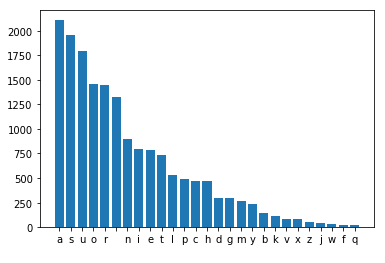

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import operator
# Initialize counter
count = Counter(data)
# Sort data
count_sorted = dict(sorted(count.items(), key=operator.itemgetter(1), reverse=True))
# Plot distribution
plt.bar(count_sorted.keys(), count_sorted.values())
plt.show()

### MC NOTE: To be clear, the y output values (softmax(Wyaa⟨t+1⟩+by)) are a probability distribution for each letter (given a preceeding letter). To generate text, we simply run a letter through the network (starting at t0), and after each y value is calculated (the probability distribution for the given letter), we sample (using np.choice) and  feed the new letter into the next step of the network! 
<img src="images/rnn_step_forward.png" style="width:700px;height:300px;">



In [9]:
x=['hello']
x is None

False

In [10]:
x = [1,2,3,4,5,10,1,2,3,4]
x[np.argmax(x)]


10

In [11]:
# GRADED FUNCTION: sample

def sample(parameters, char_to_ix, seed, x=None, random_choice=True, return_probas=False):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- python dictionary containing the parameters:
        - Waa: hidden state weights, shape=(n_hidden_neurons, n_hidden_neurons)
        - Wax: x[t] weights, shape=(n_hidden_neurons, n_feats)
        - Wya: output (y) weights, shape=(n_output_neurons, n_hidden_neurons)
        - ba: hidden state bias vector, shape=(n_hidden_neurons, 1)
        - by: output bias vector, shape=(n_output_neurons, 1)
        
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    # IN THIS EXAMPLE, N_OUTPUT_NEURONS WILL BE 27 (the vocab size)
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa = parameters['Waa']
    Wax = parameters['Wax']
    Wya = parameters['Wya']
    ba = parameters['ba']
    by = parameters['by']
    vocab_size = by.shape[0]
    n_hidden_neurons = Waa.shape[1]
    
    # Check to make sure ALL match the vocab_size of 27
    assert all([i==vocab_size for i in [Wax.shape[1], Wya.shape[0]]]), "Vocab size params do not match!" # MC addition
    # Make sure rows and columns number matchs in Waa
    assert Waa.shape[0] == Waa.shape[1], "Waa rows and columns must be equal(n_hidden_neurons)" # MC addition

    
    ### START CODE HERE ###
    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    if x is None:
        x = np.zeros((vocab_size, 1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_hidden_neurons, 1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # Idx is a flag to detect a newline character, we initialize it to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step, sample a character from a probability distribution and append 
    # its index to "indices". We'll stop if we reach 50 characters (which should be very unlikely with a well 
    # trained model), which helps debugging and prevents entering an infinite loop. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    # RUN x THROUGH THE RNN
    probas = []
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + ba)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        probas.append(y)
        
        # for grading purposes
        np.random.seed(counter + seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        if random_choice:
            idx = np.random.choice(list(range(vocab_size)), p=y.ravel())
        else:
            idx = np.argmax(y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1
        
    ### END CODE HERE ###

    if (counter == 50):
        indices.append(char_to_ix['\n'])
#     print("vocab_size: ",vocab_size)
#     print("X.shape: ",x.shape)
#     print("Wax.shape: ",Wax.shape)
#     print("a_prev.shape: ",a_prev.shape)
#     print("Waa.shape: ",Waa.shape)
#     print("y_output.shape: ",y.shape)

    if return_probas:
        return indices, probas
    else:
        return indices

In [12]:
# REMEMBER: n_feats = vocab size in nlp exercises (because you have binary vectors)
# Also vocab_size is the same as n_output because we are langauge modeling, and want a word vecotr for each output!
np.random.seed(2)
n_hidden_neurons = 100
vocab_size = 27

n_feats = vocab_size
n_output_neurons = vocab_size

# X.shape = (vocab_size, n_obs)
Wax = np.random.randn(n_hidden_neurons, n_feats)
# a.shape = (n_hidden_neurons, n_obs)
Waa = np.random.randn(n_hidden_neurons, n_hidden_neurons)
# y.shape = (n_output_neurons, n_obs)
Wya = np.random.randn(n_output_neurons, n_hidden_neurons)
ba = np.random.randn(n_hidden_neurons, 1)
by = np.random.randn(n_feats, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}


indices = sample(parameters, char_to_ix, 0)
print("\nSampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [ix_to_char[i] for i in indices])


Sampling:
list of sampled indices: [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 13, 0, 0]
list of sampled characters: ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'm', '\n', '\n']


** Expected output:**
<table>
<tr>
    <td> 
    **list of sampled indices:**
    </td>
    <td> 
    [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, <br>
    7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 5, 6, 12, 25, 0, 0]
    </td>
    </tr><tr>
    <td> 
    **list of sampled characters:**
    </td>
    <td> 
    ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', <br>
    'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', <br>
    'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'e', 'f', 'l', 'y', '\n', '\n']
    </td>
    
        
    
</tr>
</table>

## 3 - Building the language model 

It is time to build the character-level language model for text generation. 


### 3.1 - Gradient descent 

In this section you will implement a function performing one step of stochastic gradient descent (with clipped gradients). You will go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients if necessary 
- Update your parameters using gradient descent 

**Exercise**: Implement this optimization process (one step of stochastic gradient descent). 

We provide you with the following functions: 

```python
def rnn_forward(X, Y, a_prev, parameters):
    """ Performs the forward propagation through the RNN and computes the cross-entropy loss.
    It returns the loss' value as well as a "cache" storing values to be used in the backpropagation."""
    ....
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ Performs the backward propagation through time to compute the gradients of the loss with respect
    to the parameters. It returns also all the hidden states."""
    ...
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """ Updates parameters using the Gradient Descent Update Rule."""
    ...
    return parameters
```

### We will rewrite the function below, just for illustration purposes!
- Softmax: activation function
- rnn_step_forward: feed data through RNN for a single timestep
- rnn_forward: run rnn_step_forward for each timestep in X
- rnn_step_backward: feed loss value and params back through network to extract gradients for a single timestep
- rnn_backward: run rnn_step_backward for each timestep in X
- optimize: put it all together!


In [13]:
n_feats = 2
n_obs = 1
n_hidden_neurons = 5
n_output_neurons = 2

x_t = np.zeros((n_feats, n_obs))
Wax = np.random.randn(n_hidden_neurons, n_feats)
a_prev = np.random.randn(n_hidden_neurons, n_obs)
Waa = np.random.randn(n_hidden_neurons, n_hidden_neurons)
ba = np.random.randn(n_hidden_neurons, 1)

Wya = np.random.randn(n_output_neurons, n_hidden_neurons)
by = np.random.randn(n_feats, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
for key,val in parameters.items():
    print(key, val.shape)

Wax (5, 2)
Waa (5, 5)
Wya (2, 5)
ba (5, 1)
by (2, 1)


#### softmax

In [14]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

softmax([1,2,3])

array([0.09003057, 0.24472847, 0.66524096])

#### rnn_step_forward

In [15]:
def rnn_step_forward(parameters, a_prev, x):    
    # Extract params
    Waa = parameters['Waa']
    Wax = parameters['Wax']
    Wya = parameters['Wya']
    by = parameters['by'] 
    ba = parameters['ba']
    # calculate hidden state
    Wax_x = np.dot(Wax, x)
    Waa_aprev = np.dot(Waa, a_prev)
    a_next = np.tanh(Wax_x + Waa_aprev + ba)
    # calculate y value for timestep (unnormalized log probabilities for next chars, probabilities for next chars)
    y_t = softmax(np.dot(Wya, a_next) + by)  
    return a_next, y_t

a, y = rnn_step_forward(parameters, a_prev, x_t)
print("last a:", a)
print("last y:", y)

last a: [[-0.5377121 ]
 [-0.9591247 ]
 [-0.45195964]
 [-0.84850277]
 [-0.60551724]]
last y: [[0.99225591]
 [0.00774409]]


#### rnn_forward

In [16]:
def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
 
    # Iterate through each word idx, create one-hot vector representation, and store in dictionary X
    for t in range(len(X)):
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        x[t] = np.zeros((vocab_size,1)) 
        x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

#### rnn_step_backward & update_prameters

In [17]:
def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    # Update gradients for a single timestep
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients

def update_parameters(parameters, gradients, lr):
    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['ba']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

#### rnn_backward

In [18]:
def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, ba = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['ba']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(ba), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    ### START CODE HERE ###
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])
    ### END CODE HERE ###
    
    return gradients, a

In [19]:
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, 5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [20]:
np.random.seed(1)
vocab_size = 27
n_hidden_neurons = 100

n_feats = vocab_size
n_output_neurons = vocab_size

a_prev = np.random.randn(n_hidden_neurons, 1)
Wax = np.random.randn(n_hidden_neurons, n_feats)
Waa = np.random.randn(n_hidden_neurons, n_hidden_neurons)
Wya = np.random.randn(n_output_neurons, n_hidden_neurons)
ba = np.random.randn(n_hidden_neurons, 1)
by = np.random.randn(n_output_neurons, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
X = [12,3,5,11, 22, 3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165346
gradients["dWaa"][1][2] = 0.1947093153472697
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032004693
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


** Expected output:**

<table>


<tr>
    <td> 
    **Loss **
    </td>
    <td> 
    126.503975722
    </td>
</tr>
<tr>
    <td> 
    **gradients["dWaa"][1][2]**
    </td>
    <td> 
    0.194709315347
    </td>
<tr>
    <td> 
    **np.argmax(gradients["dWax"])**
    </td>
    <td> 93
    </td>
</tr>
<tr>
    <td> 
    **gradients["dWya"][1][2]**
    </td>
    <td> -0.007773876032
    </td>
</tr>
<tr>
    <td> 
    **gradients["db"][4]**
    </td>
    <td> [-0.06809825]
    </td>
</tr>
<tr>
    <td> 
    **gradients["dby"][1]**
    </td>
    <td>[ 0.01538192]
    </td>
</tr>
<tr>
    <td> 
    **a_last[4]**
    </td>
    <td> [-1.]
    </td>
</tr>

</table>

### 3.2 - Training the model 

Given the dataset of dinosaur names, we use each line of the dataset (one name) as one training example. Every 100 steps of stochastic gradient descent, you will sample 10 randomly chosen names to see how the algorithm is doing. Remember to shuffle the dataset, so that stochastic gradient descent visits the examples in random order. 

**Exercise**: Follow the instructions and implement `model()`. When `examples[index]` contains one dinosaur name (string), to create an example (X, Y), you can use this:
```python
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
```
Note that we use: `index= j % len(examples)`, where `j = 1....num_iterations`, to make sure that `examples[index]` is always a valid statement (`index` is smaller than `len(examples)`).
The first entry of `X` being `None` will be interpreted by `rnn_forward()` as setting $x^{\langle 0 \rangle} = \vec{0}$. Further, this ensures that `Y` is equal to `X` but shifted one step to the left, and with an additional "\n" appended to signify the end of the dinosaur name. 

#### More helper functions:

In [21]:
def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print ('----\n %s \n----' % (txt, ))
    
def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

def initialize_parameters(n_hidden_neurons, n_feats, n_output_neurons):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_hidden_neurons, n_feats)*0.01 # input to hidden
    Waa = np.random.randn(n_hidden_neurons, n_hidden_neurons)*0.01 # hidden to hidden
    Wya = np.random.randn(n_output_neurons, n_hidden_neurons)*0.01 # hidden to output
    ba = np.zeros((n_hidden_neurons, 1)) # hidden bias
    by = np.zeros((n_output_neurons, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba,"by": by}
    
    return parameters

In [61]:
9%4

1

#### Build model

In [51]:
# GRADED FUNCTION: model

def model(examples, ix_to_char, char_to_ix, num_iterations = 35000, n_hidden_neurons = 50, dino_names = 7, vocab_size = 27):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    examples -- should be a list of dino names!
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_feats, n_output_neurons = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_hidden_neurons, n_feats, n_output_neurons)
    for key, val in parameters.items():
        print(key, val.shape)
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # NOTE: because we have shitty custom data, we will just manually add it to function args as 'examples'
    # Build list of all dinosaur names (training examples).
#     with open("dinos.txt") as f:
#         examples = f.readlines()
#     examples = [x.lower().strip() for x in examples]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your RNN
    a_prev = np.zeros((n_hidden_neurons, 1))
    
    # Optimization loop
    for j in range(num_iterations):
        
        ### START CODE HERE ###
        
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)
        
        ### END CODE HERE ###
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result for grading purposed, increment the seed by one. 
      
            print('\n')
        
    return parameters

Run the following cell, you should observe your model outputting random-looking characters at the first iteration. After a few thousand iterations, your model should learn to generate reasonable-looking names. 

In [62]:
examples = data.split("\n")
parameters = model(examples, ix_to_char, char_to_ix)

Wax (50, 27)
Waa (50, 50)
Wya (27, 50)
ba (50, 1)
by (27, 1)
Iteration: 0, Loss: 23.090633

----
 nkzxwtdmfqoeyhsqwasjkjvu
 
----
----
 kneb
 
----
----
 kzxwtdmfqoeyhsqwasjkjvu
 
----
----
 neb
 
----
----
 zxwtdmfqoeyhsqwasjkjvu
 
----
----
 eb
 
----
----
 xwtdmfqoeyhsqwasjkjvu
 
----


Iteration: 2000, Loss: 26.648994

----
 orusaurus
 
----
----
 ipa
 
----
----
 kwusaurus
 
----
----
 on
 
----
----
 xus
 
----
----
 da
 
----
----
 us
 
----


Iteration: 4000, Loss: 24.943986

----
 oryus
 
----
----
 lon
 
----
----
 lytos
 
----
----
 on
 
----
----
 xus
 
----
----
 ed
 
----
----
 us
 
----


Iteration: 6000, Loss: 23.567811

----
 oshurus
 
----
----
 mon
 
----
----
 nytos
 
----
----
 on
 
----
----
 vus
 
----
----
 eda
 
----
----
 us
 
----


Iteration: 8000, Loss: 23.151049

----
 posaurus
 
----
----
 nnde
 
----
----
 osaurus
 
----
----
 pha
 
----
----
 us
 
----
----
 ia
 
----
----
 us
 
----


Iteration: 10000, Loss: 22.473597

----
 phus
 
----
----
 ora
 
---

### Lets break this down step by step (or TIMEstep by TIMEstep... a lil RNN pun for ya)

When run the sample funciton with a vector of zeros as x, we effectively sample the probability of getting any first letter... you'll notice that if you do the math with the zero vector, you are left with only by (everything else gets zeroed out!). **NOTE that the probability distributions created for the first letter DO NOT equal [num_first_letters / total examples]... this is because the `ba` and `Wya` which create the first probability distribution (assuming a x vector of zeros) reflect the probability of getting a letter across ALL timesteps... I think...**

```python
# NOTE X WILL BE A VECTOR OF ZEROES FOR FIRST SAMPLE
def rnn_step_forward(parameters, a_prev, x):    
    # Extract trianed params
    Waa = parameters['Waa']
    Wax = parameters['Wax']
    Wya = parameters['Wya']
    by = parameters['by'] 
    ba = parameters['ba']
    # calculate hidden state left side: SHOULD RESULT IN VECTOR OF ZEROS (because of x)
    Wax_x = np.dot(Wax, x)
    # calucate hidden state right side: SHOULD RESULT IN VECTOR OF ZEROS (because of initil a_prev)
    Waa_aprev = np.dot(Waa, a_prev)
    # calculate a_next: SHOULD REUSLT IN np.tanh('ba') because only 'ba' has non-zero values
    a_next = np.tanh(Wax_x + Waa_aprev + ba)
    # calculate y value for timestep (unnormalized log probabilities for next chars, probabilities for next chars)
    y_t = softmax(np.dot(Wya, a_next) + by)  
    return a_next, y_t
```
So the probability of any given first letter should equal:
```python
np.dot(Wya, np.tanh(ba)) + by
```
**We will try this with the parameters we trained above:**

In [24]:
import pandas as pd
# Define input 'a'
x = np.zeros((n_feats, n_obs))
#x[char_to_ix['a']] = 1
n_hidden_neurons = 50
n_feats = 27
n_obs = 1 # n_obs is always 1 because we train one letter at a time
a_prev = np.zeros((n_hidden_neurons, n_obs))

# Run input 'a' through model and extract weights
a_next, y_t = rnn_step_forward(parameters, a_prev, x)

print("y_t shape:", y_t.shape)
print("a_next shape:", a_next.shape)

#pd.DataFrame({"chars":list(ix_to_char.values()),"p|char":y_t.ravel()*100}).sort_values('p|char', ascending=False)[0:5]
test = softmax(np.dot(parameters['Wya'], np.tanh(parameters['ba']))+parameters['by'])
pd.DataFrame({"chars":list(ix_to_char.values()),
              'first_y':list(y_t),
              'first_y_manual':list(test)},
             index=range(0,27)).sort_values('first_y', ascending=False)

y_t shape: (27, 1)
a_next shape: (50, 1)


,chars,first_y,first_y_manual
21,u,[0.2317703881129463],[0.2317703881129463]
9,i,[0.18594274101664704],[0.18594274101664704]
1,a,[0.16632124510202712],[0.16632124510202712]
15,o,[0.14133007805189768],[0.14133007805189768]
5,e,[0.06260820046803531],[0.06260820046803531]
19,s,[0.049943376618633774],[0.049943376618633774]
8,h,[0.03542348337951588],[0.03542348337951588]
12,l,[0.03425879932578105],[0.03425879932578105]
18,r,[0.0234505766924641],[0.0234505766924641]
25,y,[0.012723458040856703],[0.012723458040856703]


Once we have selected a letter using a `np.random.choice(p=y_t)` based off y_t probability distribution (which will always remain the same for the first y_t as long as paramenters remain the same), then we take that sample, and the hidden state output (a_next), and feed it into the next timestep of the RNN. This process keeps repeating until we get either 50 characters or we hit a newline character!

##### NOTE: If we dont use np.random.choice, we will ALWAYS get the same string of characters, as the paramater weights are not changing. See below: 

In [25]:
for i in range(5):
    idxs = sample(parameters, char_to_ix, seed=np.random.randint(1,1000), x=None, random_choice=False)
    print(''.join([ix_to_char[i] for i in idxs]))

us

us

us

us

us



In [26]:
for i in range(5):
    idxs = sample(parameters, char_to_ix, seed=np.random.randint(1,1000), x=None, random_choice=True)
    print(''.join([ix_to_char[i] for i in idxs]))

on

odan

a

ia

nychanus



#### Check out the probabilities distributions for each timestep:

In [27]:
# Use return_probas arg to access y (probability distribution values) for each timestep
idxs, probas = sample(parameters, char_to_ix, seed=np.random.randint(1,1000), x=None, random_choice=True, return_probas=True)
probas_matrix = np.hstack(probas)
print(len(probas))
print(probas_matrix.shape)

3
(27, 3)


In [28]:
[ix_to_char[i] for i in idxs]

['u', 's', '\n']

In [29]:
# Turn into dataframe
index = pd.DataFrame(probas_matrix, index=list(ix_to_char.values()))
index.style.highlight_max(axis=0)

,0,1,2
,0.0056882,0.00378488,0.838969
a,0.166321,0.00415298,0.139567
b,0.00221151,0.00193776,2.90913e-05
c,0.00762716,0.00420472,0.000584953
d,0.00275756,0.0131657,6.43881e-05
e,0.0626082,0.00724906,0.000749257
f,0.000183355,0.000201253,4.53154e-06
g,0.00210132,0.00455349,1.05742e-05
h,0.0354235,0.00104666,0.000924852
i,0.185943,0.00150103,0.00197814


## Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implemetation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.

If your model generates some non-cool names, don't blame the model entirely--not all actual dinosaur names sound cool. (For example, `dromaeosauroides` is an actual dinosaur name and is in the training set.) But this model should give you a set of candidates from which you can pick the coolest! 

This assignment had used a relatively small dataset, so that you could train an RNN quickly on a CPU. Training a model of the english language requires a much bigger dataset, and usually needs much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favoriate name is the great, undefeatable, and fierce: Mangosaurus!

<img src="images/mangosaurus.jpeg" style="width:250;height:300px;">

## 4 - Writing like Nietzsche!

Ok, now we are going to create a language model using keras! This time we will use the Nietzsche corpus. This was taken from the keras website: 
https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py

##### NOTE: That we are going to build  a MANY TO ONE model. So we feed in a sequence, and the next word is predicted. Then we feed that same sequence in with the next predicted word to get the next word, and so on and so on. 

In [1]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, RNN
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

Using TensorFlow backend.


#### 1. Get data
Should have a character length of ~600k

In [2]:
from keras.utils.data_utils import get_file
import io

path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')

with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()

# Replace '\n' chars with spaces
text = text.replace("\n"," ")
print('corpus length:', len(text))
text[0:100]

corpus length: 600893


'preface   supposing that truth is a woman--what then? is there not ground for suspecting that all ph'

#### 2. Get unique chars and indices

In [3]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(indices_char)

total chars: 56
{0: ' ', 1: '!', 2: '"', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: ':', 20: ';', 21: '=', 22: '?', 23: '[', 24: ']', 25: '_', 26: 'a', 27: 'b', 28: 'c', 29: 'd', 30: 'e', 31: 'f', 32: 'g', 33: 'h', 34: 'i', 35: 'j', 36: 'k', 37: 'l', 38: 'm', 39: 'n', 40: 'o', 41: 'p', 42: 'q', 43: 'r', 44: 's', 45: 't', 46: 'u', 47: 'v', 48: 'w', 49: 'x', 50: 'y', 51: 'z', 52: 'ä', 53: 'æ', 54: 'é', 55: 'ë'}


#### 3. Extract staggered sequences from text corpus
- We are going to build a many to one model! 
- So we feed in a string of 40 characters, and predict the next one

In [4]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5
X_seqs = []
Y_seqs = []
for i in range(0, len(text) - maxlen, step):
    X_seqs.append(text[i: i + maxlen])
    Y_seqs.append(text[i + maxlen])
print('nb sequences:', len(X_seqs))

nb sequences: 120171


In [8]:
X_seqs[3]

'sing that truth is a woman--what then? i'

In [104]:
# So we feed in a long string, and the model should predict the next letter... "e"!!!
print("X:", X_seqs[3])
print("y:", Y_seqs[3])

X: sing that truth is a woman--what then? i
y: s


#### 4. Vectorize Data
Data shape should be (num_sentences, max_sent_length, num_chars)

In [10]:
num_sents = len(X_seqs)
num_feats = len(chars) # num_chars

x = np.zeros((num_sents, maxlen, num_feats), dtype=np.bool)
y = np.zeros((num_sents, num_feats), dtype=np.bool) # Only need on vector per sequence (only one character in y values!)

# Vectorize X sequences to BINARY word embeddings
for i, sentence in enumerate(X_seqs):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[Y_seqs[i]]] = 1

In [11]:
# First 5 word indices of first sequence
[char_indices[i] for i in X_seqs[0]][0:5]

[41, 43, 30, 31, 26]

In [12]:
# First five vectors of first sequence
for row in x[0][0:5]:
    print(np.argmax(row))

41
43
30
31
26


#### 5. Build the mode: a single LSTM

Dense layer on top:
- Keras LSTM neurons DO NOT automatically run the hidden state for each timestep through the softmax activation... 
- As such, to get the softmax of EACH timestep's hidden state (what we have called `y`), then we need to add a Dense layer on top. 

A LSTM layer operates in such a way that it accepts input in the form (number_of_timesteps, dimensions_of_each_item). A very import parameter here is the `return_sequences` arg: 
- `Dense(num_feats, activation='softmax')`
    - return_sequences=False: the model will return only the last output in the sequence (many-to-one)
    - return_sequences=True: the model will return the output from each timestep (many-to-many).

Token from this post: https://datascience.stackexchange.com/questions/26401/how-to-implement-one-to-many-and-many-to-many-sequence-prediction-in-keras

**First lets experiment with some different model architectures to get a better understanding of how keras works:**

### MODEL 1: Simple RNN
- 1 SimpleRNN layer with 10 neurons
- Input sequence length = 7
- n_feats per sequence timestep = 5 features
- Return ALL hidden states WITHOUT softmax
- Number of params should be:
    - Wax (n_feats\*n_neurons) = 50 
    - + Waa (n_neurons\*n_neurons) = 100
    - + ba (n_neurons) = 10
    - = 160 params
- Output shape should be:
    - Many-to-one: (num_obs, n_neurons)
    - Many-to-many: (num_obs, n_nuerons, num_timesteps)
    
#### Note the output shape will be a little arranged different (n_steps, n_neurons vs n_neurons, nsteps) compared to our manual implementation, but the numbers will be the same.

<img src="images/rnn1.png" style="width:450;height:300px;">


In [13]:
from keras.layers import SimpleRNN
from keras.layers import LSTM

In [14]:
model = Sequential()
model.layers

[]

In [21]:
# build the model: a single RNN
import tensorflow as tf
tf.reset_default_graph()
tsteps = 7
feats_per_tstep = 5
model = Sequential()
model.add(SimpleRNN(10, input_shape=(tsteps, feats_per_tstep), return_sequences=True))
model.add(SimpleRNN(10, input_shape=(tsteps, feats_per_tstep), return_sequences=True))
model.add(SimpleRNN(10, input_shape=(tsteps, feats_per_tstep), return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 7, 10)             160       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 7, 10)             210       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 7, 10)             210       
Total params: 580
Trainable params: 580
Non-trainable params: 0
_________________________________________________________________


In [201]:
# Turn off return sequences
model = Sequential()
model.add(SimpleRNN(10, input_shape=(tsteps, feats_per_tstep), return_sequences=False))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_21 (SimpleRNN)    (None, 10)                160       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


#### Add a dense layer:
- `return_sequences = True`
    - Should return output shape (n_obs, n_tsteps, n_output_neurons)
    - params should be (n_hidden_neurons \* n_output_neurons) + output_bias = 10\*2 + 2
        - output_bias = n_output_neurons
        


- `return_sequences = False`
    - Should return output shape (n_obs, n_output_neurons)
    - params should be (n_hidden_neurons \* n_output_neurons) + output_bias = 10\*2 + 2
        - output_bias = n_output_neurons

In [211]:
# Add a dense layer
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(tsteps, feats_per_tstep), return_sequences=True))
model.add(Dense(units=2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_31 (SimpleRNN)    (None, 7, 10)             160       
_________________________________________________________________
dense_19 (Dense)             (None, 7, 2)              22        
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________


### MODEL 2: LSTM
- 1 LSTM layer with 128 neurons
- Input sequence length = 7
- n_feats per sequence timestep = 5 features
- Return ALL hidden states WITHOUT softmax
- Remember we stack X and a_prev and cooresponding matrices for efficiency. Here are the params below:
    - Wf - (n_hidden_neurons, n_hidden_neurons + n_feats) = 128 \* (128+5) = 17024 
    - bf - (n_hidden_neurons, 1) = 128
    - Wu - (n_hidden_neurons, n_hidden_neurons + n_feats) = 128 \* (128+5) = 17024
    - bu - (n_hidden_neurons, 1) = 128
    - Wc - (n_hidden_neurons, n_hidden_neurons + n_feats) = 128 \* (128+5) = 17024
    - bc - (n_hidden_neurons, 1) = 128
    - Wo - (n_hidden_neurons, n_hidden_neurons + n_feats) = 128 \* (128+5) = 17024
    - bo - (n_hidden_neurons, 1) = 128
    - Wy - (n_output_neurons, n_hidden_neurons) = 2 \* 128 = 256
    - by - (n_output_neurons, 1) = 2
    - TOTAL PARAMS: 68,866


- Output shape should be:
    - Many-to-one: (num_obs, n_neurons)
    - Many-to-many: (num_obs, n_nuerons, num_timesteps)
    
![](Images/22.png)


In [242]:
# build the model: a single RNN
tsteps = 7
feats_per_tstep = 5
model = Sequential()
model.add(LSTM(128, input_shape=(tsteps, feats_per_tstep), return_sequences=False))
model.add(Dense(units=2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________


### Now actually build and train the model!

In [147]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, num_feats)))
model.add(Dense(num_feats, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


Build model...


In [151]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x[0:2000], y[0:2000],
          batch_size=128,
          epochs=60,
          callbacks=[print_callback])

Epoch 1/60
2000/2000 [==============================] - 4s 2ms/step - loss: 3.2682

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " be promised, but not feelings, for thes"
 be promised, but not feelings, for thesnenenenn neneeee  nenren nenn nin n entieeni eeineeenienie eeeeee ne  e e eeeneeneeneern  neennenin eee eernennneneeeneenenee enin e nneiieenneeese t neennene inn ie ee n nininee eennennnn e ee ennnenneinneeee nnineinee eeeeeei enn eienneeeeeeeeneenenn  nneneeniin  n e ennnn niee en nnee e ennenn eeienine  ieniee entieiteie enen ieeenennennnieie einneee nne t nen ineieeie n ee enninienneeee nn e i
----- diversity: 0.5
----- Generating with seed: " be promised, but not feelings, for thes"
 be promised, but not feelings, for thesnnn  ieeinn etde  ifn  s innee ainnn,e se nnin neiee e ie t ny inenneadain n iie rnene ianieaerieteeninrie, ieeee i i nnei i enitnrerieninenn einnn rrenen aneenieoie enurineeninns innennenenreii t hehelesnneeeenr e

In [154]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               94720     
_________________________________________________________________
dense_1 (Dense)              (None, 56)                7224      
Total params: 101,944
Trainable params: 101,944
Non-trainable params: 0
_________________________________________________________________


The model is very similar to the one you have built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of python to simplify the code 

If you want to learn more, you can also check out the Keras Team's text generation implementation on GitHub: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py.

Congratulations on finishing this notebook! 

**References**:
- This exercise took inspiration from Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086. To learn more about text generation, also check out Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
- For the Shakespearian poem generator, our implementation was based on the implementation of an LSTM text generator by the Keras team: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py 